In [21]:
import pandas as pd
df = pd.read_csv('data/train.csv')[['id', 'SMILES', 'Tm']]
df_test = pd.read_csv('data/test.csv')[['id', 'SMILES']]
df.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2662 non-null   int64  
 1   SMILES  2662 non-null   object 
 2   Tm      2662 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 666 entries, 0 to 665
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      666 non-null    int64 
 1   SMILES  666 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.5+ KB


In [22]:
import torch
from torch.utils.data import Dataset
from torch_geometric.data import Data
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from tqdm import tqdm
import re
from rdkit.Chem import rdFingerprintGenerator

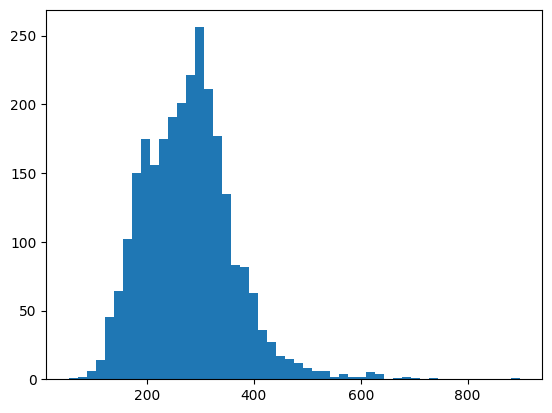

count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64


In [23]:
import matplotlib.pyplot as plt
plt.hist(df['Tm'], bins=50)
plt.show()
print(df['Tm'].describe())

In [ ]:
import pandas as pd
import re

# Örnek veriyi dataframe'e koyalım (Senin df'in zaten var)
# df = ...

def smiles_tokenizer(smiles):
    """
    SMILES stringini atom ve yapılara göre doğru böler.
    Sıralama Önemli: Önce 2 harfliler, sonra 1 harfliler taranmalı.
    """
    # Regex Mantığı:
    # 1. Köşeli parantez içindeki her şeyi tek token say: \[.*?\]
    # 2. İki harfli kritik elementleri yakala: Cl, Br, Si, Na vs.
    # 3. Geri kalan tek karakterleri yakala: .
    pattern =  r"(\[[^\]]+\]|Cl|Br|.)"
    
    tokens = re.findall(pattern, smiles)
    return tokens

# 1. Tokenleri oluştur
all_tokens = []
for smile in df['SMILES']:
    all_tokens.extend(smiles_tokenizer(smile))

# 2. Tekrar Saydır
token_counts = pd.Series(all_tokens).value_counts()


print("--- DÜZELTİLMİŞ SEMBOL SAYILARI ---")
print(token_counts)

--- DÜZELTİLMİŞ SEMBOL SAYILARI ---
C       12887
c        8892
(        3630
)        3630
1        3080
O        2505
=        1663
2         892
Cl        845
N         781
F         575
Br        256
3         166
S         149
n         146
#         131
4          52
[Si]       51
I          47
P          23
5          14
6           4
7           2
Name: count, dtype: int64


In [27]:
# Veri setindeki tüm unique semboller (Frekans sırasına göre)
vocab_list = [
    'C', 'c', '(', ')', '1', 'O', '=', '2', 'Cl', 'N', 'F', 'Br', 
    '3', 'S', 'n', '#', '4', '[Si]', 'I', 'P', '5', '6', '7'
]

import pandas as pd
import re

# Regex desenimiz (Cl, Br, [Si] ve diğer her şey)
pattern = r"(\[[^\]]+\]|Cl|Br|Si|.)"

# Fonksiyon: SMILES'ı regex ile bölüp parça sayısını (token count) döndürür
def get_token_count(smiles):
    tokens = re.findall(pattern, smiles.strip())
    return len(tokens)

# Apply işlemi
df['token_count'] = df['SMILES'].apply(get_token_count)

df_test['token_count'] = df_test['SMILES'].apply(get_token_count)

# Kontrol edelim
print(df[['SMILES', 'token_count']].head())
print(df_test[['SMILES', 'token_count']].max())

                        SMILES  token_count
0        FC1=C(F)C(F)(F)C1(F)F           21
1  c1ccc2c(c1)ccc3Nc4ccccc4c23           27
2          CCN1C(C)=Nc2ccccc12           19
3                   CC#CC(=O)O           10
4                    CCCCC(S)C            9
SMILES         n1ccc(cc1)c2ncccc2
token_count                    55
dtype: object


In [29]:
print(df["token_count"].describe())

print(df_test["token_count"].describe())


count    2662.000000
mean       15.184448
std         7.062411
min         2.000000
25%        11.000000
50%        14.000000
75%        18.000000
max        69.000000
Name: token_count, dtype: float64
count    666.000000
mean      15.060060
std        6.617543
min        2.000000
25%       10.000000
50%       15.000000
75%       19.000000
max       55.000000
Name: token_count, dtype: float64


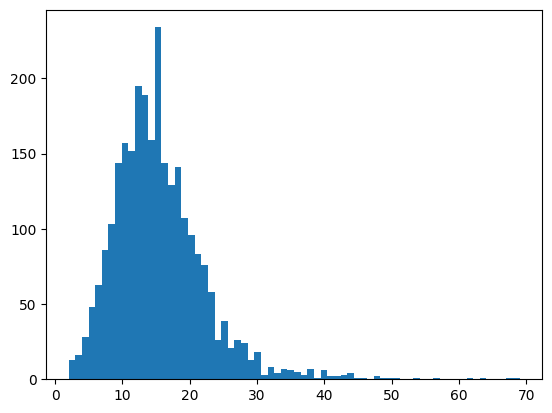

count    2662.000000
mean       15.184448
std         7.062411
min         2.000000
25%        11.000000
50%        14.000000
75%        18.000000
max        69.000000
Name: token_count, dtype: float64


In [8]:
import matplotlib.pyplot as plt
plt.hist(df['token_count'], bins=68)
plt.show()
print(df['token_count'].describe())

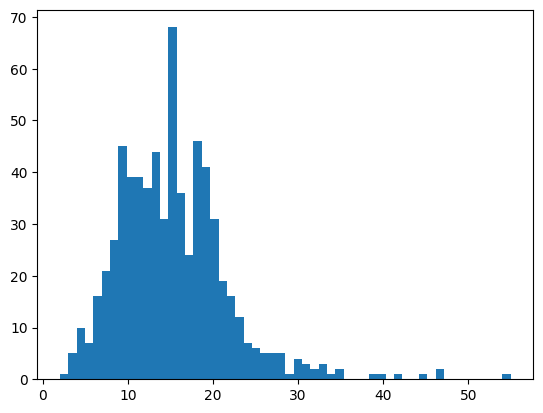

count    666.000000
mean      15.060060
std        6.617543
min        2.000000
25%       10.000000
50%       15.000000
75%       19.000000
max       55.000000
Name: token_count, dtype: float64


In [30]:
import matplotlib.pyplot as plt
plt.hist(df_test['token_count'], bins=54)
plt.show()
print(df_test['token_count'].describe())

In [9]:
# how any row has token_count > 40
print(df[df['token_count'] > 35].shape[0])



46


In [10]:
# drop rows with token_count > 40
df = df[df['token_count'] <= 33]

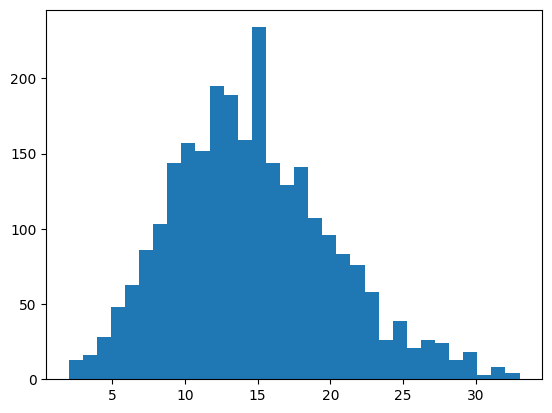

count    2603.000000
mean       14.581252
std         5.745150
min         2.000000
25%        10.000000
50%        14.000000
75%        18.000000
max        33.000000
Name: token_count, dtype: float64


In [11]:
import matplotlib.pyplot as plt
plt.hist(df['token_count'], bins=32)
plt.show()
print(df['token_count'].describe())

0.5219755810985899


<Axes: xlabel='token_count'>

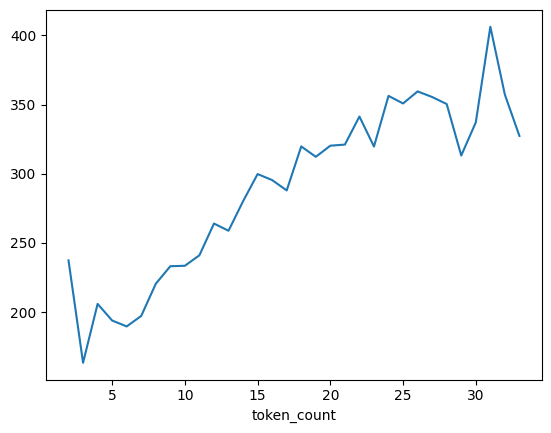

In [12]:
# correlation
print(df['token_count'].corr(df['Tm']))
# plot token_count vs avg tm on that token count
df.groupby('token_count')['Tm'].mean().plot(kind='line')

In [13]:
smile = df['SMILES'][0]
mol = Chem.MolFromSmiles(smile)
print(mol)

In [14]:
# 1. Molekülden fingerprint üretiyoruz
mfgen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
fp = mfgen.GetFingerprint(mol)

arr = np.zeros((0,), dtype=np.int8)
Chem.DataStructs.ConvertToNumpyArray(fp, arr)
print([a for a in arr if a != 0])

[np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1), np.int8(1)]


In [15]:
def _get_graph(smile):
    mol = Chem.MolFromSmiles(smile)
    if mol is None:
        print(f"Invalid SMILES: {smile}")
        return Data(x=torch.zeros((1, 1), dtype=torch.float), edge_index=torch.zeros((2, 0), dtype=torch.long))

    # --- ÖNEMLİ EKLEME ---
    # Erime noktası polariteye bağlıdır, kısmi yükleri hesaplatıyoruz.
    AllChem.ComputeGasteigerCharges(mol)
    
    # Not: Eğer Hidrojenleri ayrı birer node (yuvarlak) olarak görmek istersen:
    # mol = Chem.AddHs(mol) 
    # satırını buraya ekleyebilirsin. Ama genelde implicit (aşağıdaki gibi) yeterlidir.

    # Atom Features
    atom_features = []
    for atom in mol.GetAtoms():
        feats = [
            # 1. Temel Kimlik
            atom.GetAtomicNum(),
            
            # 2. Yapısal Bilgiler
            atom.GetTotalDegree(),
            int(atom.GetIsAromatic()),
            int(atom.GetHybridization()),
            int(atom.IsInRing()), # Atom halkada mı? (Önemli)
            
            # 3. ERİME NOKTASI İÇİN KRİTİK FİZİKSEL ÖZELLİKLER
            # Hidrojen Bağ Potansiyeli (Data'da H yok demiştin, işte buraya ekliyoruz)
            atom.GetTotalNumHs(), 
            
            # Atom Kütlesi (Van der Waals kuvvetleri için - 0.01 ile normalize)
            atom.GetMass() * 0.01,
            
            # Yük Bilgisi (Polarite)
            atom.GetFormalCharge(),
            # Gasteiger Partial Charge (Hesaplanamazsa 0.0 ver)
            float(atom.GetProp('_GasteigerCharge')) if atom.HasProp('_GasteigerCharge') else 0.0
        ]
        atom_features.append(feats)
    
    x = torch.tensor(atom_features, dtype=torch.float)

    # Edge Features & Connectivity
    row, col = [], []
    edge_features = []
    
    bond_type_map = {
        Chem.rdchem.BondType.SINGLE: 1,
        Chem.rdchem.BondType.DOUBLE: 2,
        Chem.rdchem.BondType.TRIPLE: 3,
        Chem.rdchem.BondType.AROMATIC: 4
    }

    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        
        # Add bidirectional edges (Graf yönsüz olduğu için gidiş-dönüş ekliyoruz)
        row += [start, end]
        col += [end, start]
        
        b_type = bond_type_map.get(bond.GetBondType(), 0)
        b_ring = int(bond.IsInRing())
        
        # Ekstra: Bağın konjuge olup olmadığı (Erime noktası için kararlılık göstergesi)
        b_conj = int(bond.GetIsConjugated()) 

        feat = [b_type, b_ring, b_conj]
        edge_features += [feat, feat] 

    edge_index = torch.tensor([row, col], dtype=torch.long)
    edge_attr = torch.tensor(edge_features, dtype=torch.float)

    # PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

In [16]:
print(smile)
data = _get_graph(smile)
print(data["x"])
print(data["edge_index"])
print(data["edge_attr"])


FC1=C(F)C(F)(F)C1(F)F
tensor([[ 9.0000,  1.0000,  0.0000,  4.0000,  0.0000,  0.0000,  0.1900,  0.0000,
         -0.2017],
        [ 6.0000,  3.0000,  0.0000,  3.0000,  1.0000,  0.0000,  0.1201,  0.0000,
          0.2137],
        [ 6.0000,  3.0000,  0.0000,  3.0000,  1.0000,  0.0000,  0.1201,  0.0000,
          0.2137],
        [ 9.0000,  1.0000,  0.0000,  4.0000,  0.0000,  0.0000,  0.1900,  0.0000,
         -0.2017],
        [ 6.0000,  4.0000,  0.0000,  4.0000,  1.0000,  0.0000,  0.1201,  0.0000,
          0.3699],
        [ 9.0000,  1.0000,  0.0000,  4.0000,  0.0000,  0.0000,  0.1900,  0.0000,
         -0.1910],
        [ 9.0000,  1.0000,  0.0000,  4.0000,  0.0000,  0.0000,  0.1900,  0.0000,
         -0.1910],
        [ 6.0000,  4.0000,  0.0000,  4.0000,  1.0000,  0.0000,  0.1201,  0.0000,
          0.3699],
        [ 9.0000,  1.0000,  0.0000,  4.0000,  0.0000,  0.0000,  0.1900,  0.0000,
         -0.1910],
        [ 9.0000,  1.0000,  0.0000,  4.0000,  0.0000,  0.0000,  0.1900,  0.000

In [17]:
from dataset import SmilesTokenizer
tokenizer = SmilesTokenizer()

In [18]:
def _get_sequence(smile):    
    token_ids = tokenizer.encode(smile)
    return torch.tensor(token_ids, dtype=torch.long)

In [19]:
token = _get_sequence(smile)
print(token)
print(token.shape)

tensor([15,  5,  9, 11,  5,  7, 15,  8,  5,  7, 15,  8,  7, 15,  8,  5,  9,  7,
        15,  8, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])
torch.Size([32])
